# Import dependencies

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image
from glob import glob
import numpy as np
import os

AUTOTUNE = tf.data.AUTOTUNE

# Look the data


In [4]:
def visualize2xn(first, second):
    n = min(len(first), len(second))
    fig, axs = plt.subplots(n, 2, figsize=(12,32))
    for i in range(n):
        axs[i, 0].imshow(first[i])
        axs[i, 1].imshow(second[i])
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.show()

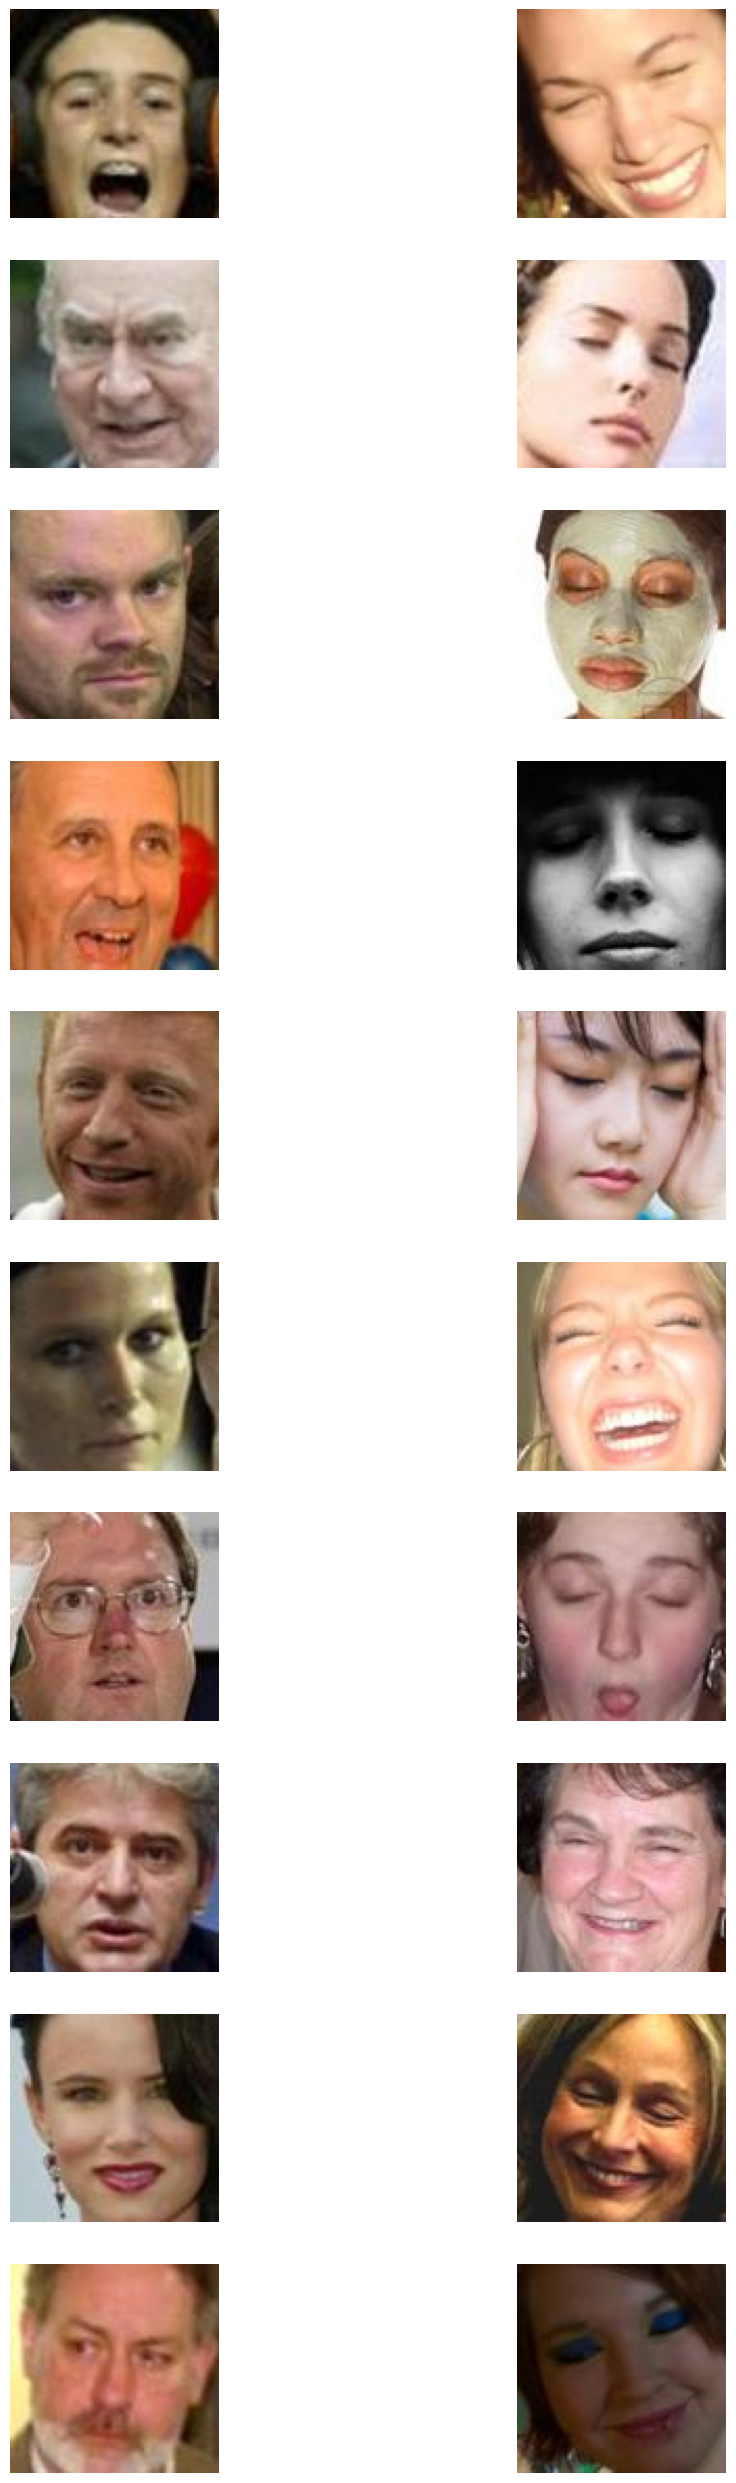

In [5]:
files = glob('dataset_B_FacialImages/*/*')
IMAGE_LENGHT = 10
opened_eyes = [filename for filename in files if 'open' in filename.lower()][:IMAGE_LENGHT]
closed_eyes = [filename for filename in files if 'closed' in filename.lower()][:IMAGE_LENGHT]

opened_eyes = list(map(lambda x: np.asarray(Image.open(x).convert('RGB')), opened_eyes))
closed_eyes = list(map(lambda x: np.asarray(Image.open(x).convert('RGB')), closed_eyes))

visualize2xn(opened_eyes, closed_eyes)



# Preprocess data

In [6]:
# get filenames
base_dataset = 'dataset_B_FacialImages'
list_ds = tf.data.Dataset.list_files(os.sep.join([base_dataset, '*', '*']), shuffle=True, seed=42)
# class names shouldn't have period '.'
# opend eye is 0 and closed eye is 1 regarding the index in the array
class_names = np.array(sorted([dirname for dirname in os.listdir(base_dataset) if '.' not in dirname], reverse=True))
label_2_class = {i:key for i, key in enumerate(class_names)}

# get train and validation size
image_count = len(list_ds)
val_size = int(image_count*.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Metal device set to: Apple M1 Max


2023-04-24 10:57:51.777052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 10:57:51.777534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
WIDTH = 100
HEIGHT = 100

# get the label from the image path
def get_labels(img_path):
    parts = tf.strings.split(img_path, os.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    return img

def process_path(img_path):
    label = get_labels(img_path)
    img = decode_img(img_path)
    return img, label

## Data augmentation

2023-04-24 11:03:25.979335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


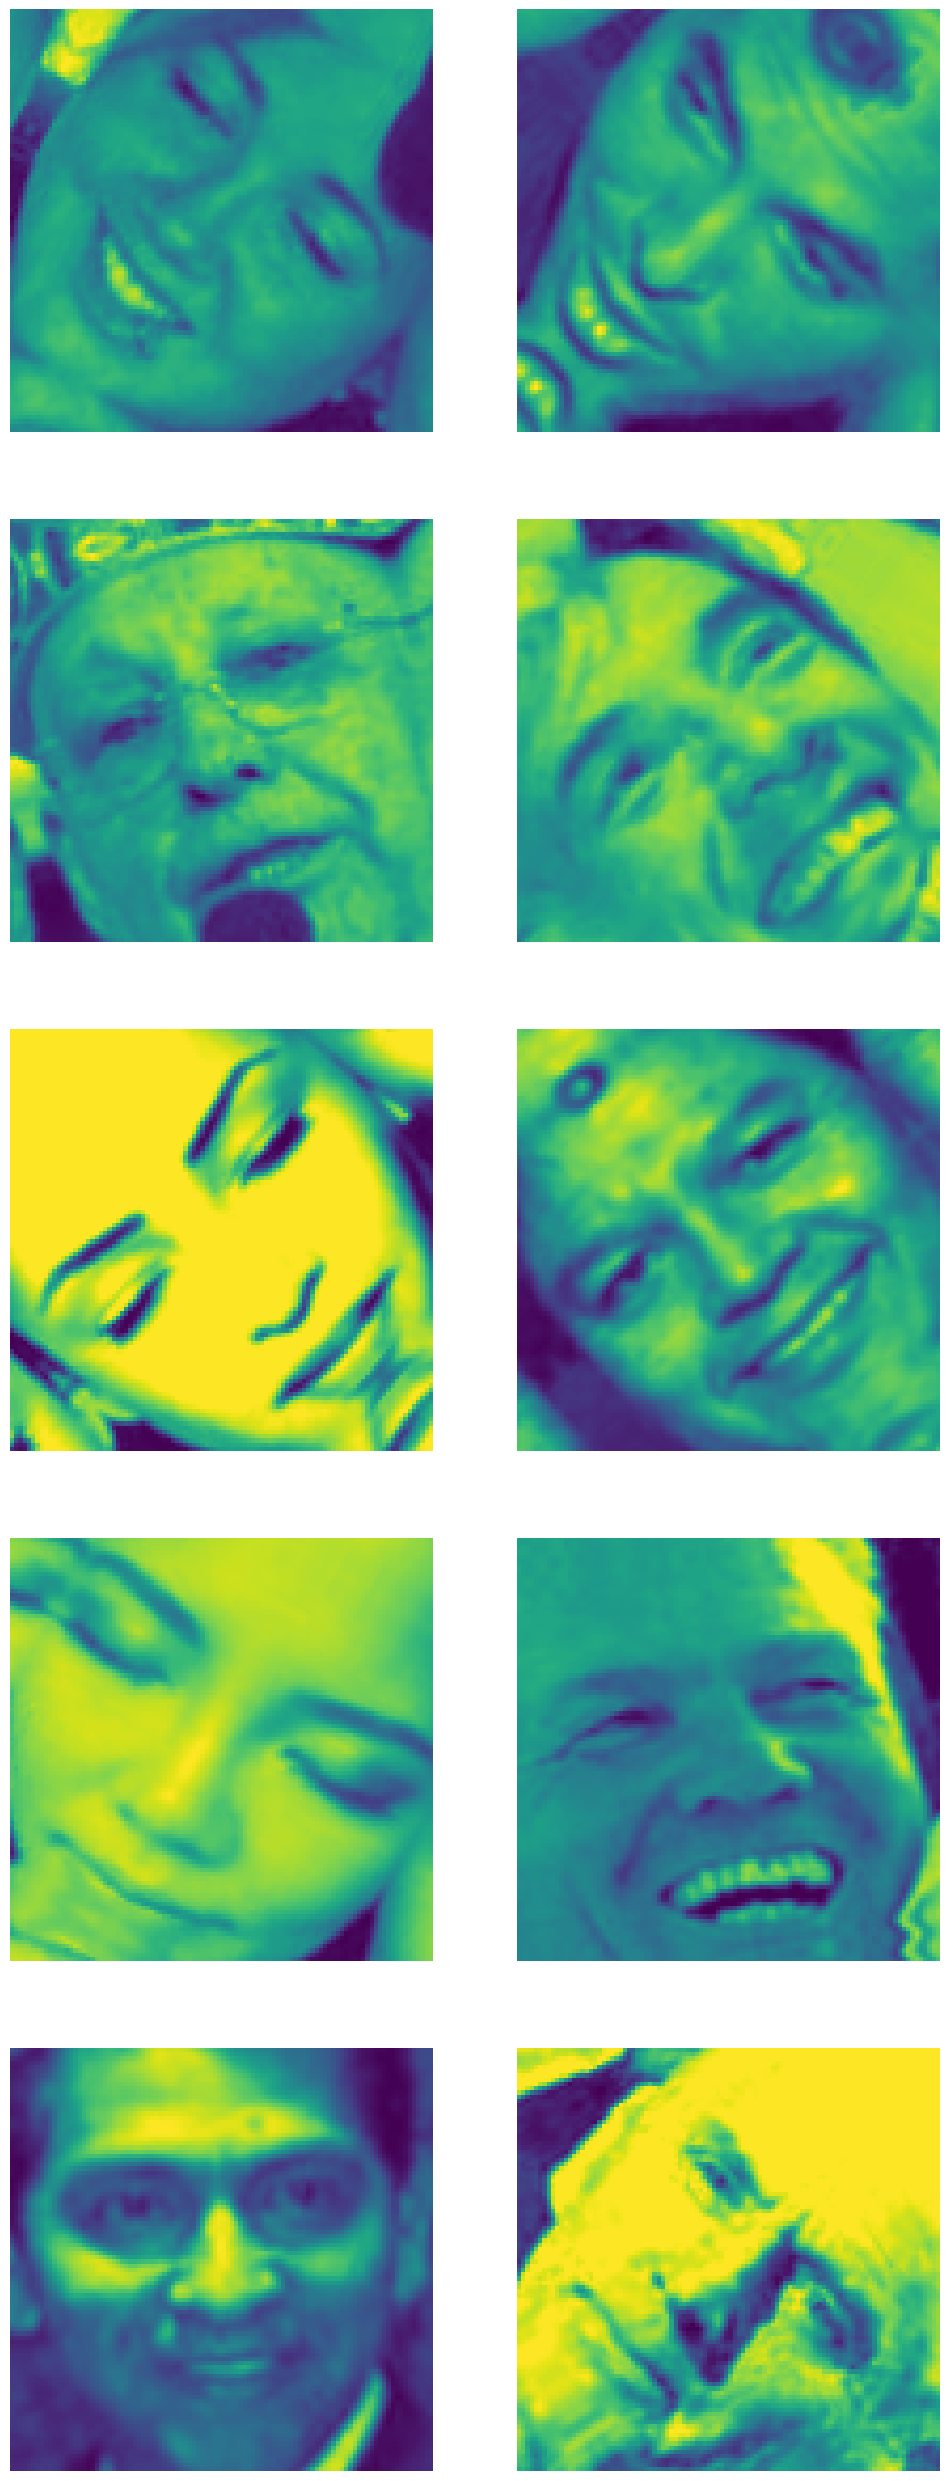

In [18]:
train_data = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_data = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

data_augmentation = tf.keras.models.Sequential([
    layers.RandomZoom(.1, .1),
    layers.RandomBrightness(.2),
    layers.RandomContrast(.2),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(.2),
    
    ])
sample_data = train_data.take(10)
sample_augmented_data = sample_data.map(lambda x, y: (data_augmentation(x, training=True), y))
sample_augmented_data = [i[0] for i in sample_augmented_data.as_numpy_iterator()]
visualize2xn(sample_augmented_data[:5], sample_augmented_data[5:])


# Neural Network designing